# Stock Market and News Sentiment Predictor

**Author:** Pratham Kumar <br>
**Date:** December 2024


## Project Overview

This project builds a stock movement prediction system combining two complementary approaches:

1. **Stock Price History (Time Series Analysis):**  
   We analyze historical price patterns using ARIMA models to forecast future prices based purely on temporal trends.

2. **News Headlines (Sentiment Analysis):**  
   Market prices are heavily influenced by news. We analyze financial headlines and compute sentiment scores to gauge market mood.

3. **Ensemble Prediction:**  
   We combine ARIMA forecasts with sentiment signals to generate robust predictions of short-term stock movements (UP/DOWN).

**Key Innovation:** Integrating **quantitative data (prices)** with **qualitative data (news sentiment)** for more realistic market prediction.


In [20]:
import sys
import subprocess

def install(pkg):
    try:
        __import__(pkg)
    except Exception:
        print(f"Installing {pkg}...")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

packages = {
    'yfinance': 'yfinance',
    'textblob': 'textblob',
    'statsmodels': 'statsmodels',
    'sklearn': 'scikit-learn',
    'nbformat': 'nbformat'
}

for mod, pkg in packages.items():
    try:
        __import__(mod)
    except Exception:
        print(f"Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

try:
    from textblob import download_corpora
    download_corpora.download_all()
except Exception:
    pass


[nltk_data] Downloading package brown to C:\Users\Pratham
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Pratham
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Pratham
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Pratham Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to C:\Users\Pratham
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to C:\Users\Pratham
[nltk_data]     Kumar\AppData\Roaming\nltk_da

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from datetime import datetime, timedelta

import yfinance as yf
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)



In [22]:
TICKER = 'AAPL'
START_DATE = '2022-01-01'
END_DATE = '2023-01-01' 

print(f'Downloading {TICKER} from {START_DATE} to {END_DATE}...')
stock_data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
stock_data = stock_data.reset_index()

print(stock_data.head())

Price        Date       Close        High         Low        Open     Volume
Ticker                   AAPL        AAPL        AAPL        AAPL       AAPL
0      2022-01-03  178.443100  179.296061  174.227380  174.345024  104487900
1      2022-01-04  176.178391  179.354901  175.609755  179.050979   99310400
2      2022-01-05  171.492111  176.639228  171.217600  176.090204   94537600
3      2022-01-06  168.629318  171.864651  168.276373  169.315597   96904000
4      2022-01-07  168.795959  170.727354  167.678301  169.501851   86709100


In [23]:
print('Stock Data Summary:')
print('-'*50)
display(stock_data[['Open','High','Low','Close','Volume']].describe())

print(stock_data.isnull().sum())

Stock Data Summary:
--------------------------------------------------


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,152.203231,154.272925,150.127143,152.234923,8.791038e+07
std,12.674761,12.544634,12.722836,12.666916,2.365699e+07
min,126.210022,128.142773,124.119514,124.287148,3.519590e+07
25%,142.106511,144.610543,140.033380,142.450706,7.229740e+07
50%,151.406305,153.195604,149.371369,151.485016,8.373720e+07
75%,163.304633,165.349869,160.990394,162.973114,9.693705e+07
max,179.050979,179.354901,175.609755,178.443100,1.826020e+08


Price   Ticker
Date              0
Close   AAPL      0
High    AAPL      0
Low     AAPL      0
Open    AAPL      0
Volume  AAPL      0
dtype: int64


In [24]:
# Synthetic news headlines for demo purposes
news_templates = [
    'Apple launches new iPhone with advanced features',
    'Concerns rise over global chip shortage affecting Apple',
    'Apple stock surges after record earnings report',
    'Investors worry about inflation and market volatility',
    'Positive outlook as Apple expands into new markets',
    'Apple announces major partnership deal',
    'Tech sector faces regulatory challenges',
    'Apple revenue beats Wall Street expectations',
    'Market uncertainty affects big tech stocks',
    'Apple innovation drives strong stock momentum',
    'Supply chain disruptions impact Apple production',
    'Apple services revenue hits all-time high',
    'Analysts upgrade Apple stock price targets',
    'Competition intensifies in smartphone market',
    'Apple announces significant stock buyback program'
]

news_data = pd.DataFrame({
    'date': stock_data['Date'],
    'headline': [news_templates[i % len(news_templates)] for i in range(len(stock_data))]
})

print(news_data.head())

        date                                           headline
0 2022-01-03   Apple launches new iPhone with advanced features
1 2022-01-04  Concerns rise over global chip shortage affect...
2 2022-01-05    Apple stock surges after record earnings report
3 2022-01-06  Investors worry about inflation and market vol...
4 2022-01-07  Positive outlook as Apple expands into new mar...


In [25]:
stock_data['Return'] = stock_data['Close'].pct_change()
stock_data['Trend'] = (stock_data['Return'] > 0).astype(int)
stock_data['MA_5'] = stock_data['Close'].rolling(5).mean()
stock_data['MA_20'] = stock_data['Close'].rolling(20).mean()
stock_data['Volatility'] = stock_data['Return'].rolling(20).std()

print('Stock features computed. Sample:')
print(stock_data[['Date','Close','Return','Trend','MA_5','MA_20']].head(10))

Stock features computed. Sample:
Price        Date       Close    Return Trend        MA_5 MA_20
Ticker                   AAPL                                  
0      2022-01-03  178.443100       NaN     0         NaN   NaN
1      2022-01-04  176.178391 -0.012691     0         NaN   NaN
2      2022-01-05  171.492111 -0.026600     0         NaN   NaN
3      2022-01-06  168.629318 -0.016693     0         NaN   NaN
4      2022-01-07  168.795959  0.000988     1  172.707776   NaN
5      2022-01-10  168.815582  0.000116     1  170.782272   NaN
6      2022-01-11  171.648941  0.016784     1  169.876382   NaN
7      2022-01-12  172.090134  0.002570     1  169.995987   NaN
8      2022-01-13  168.815582 -0.019028     0  170.033240   NaN
9      2022-01-14  169.678329  0.005111     1  170.209714   NaN


In [26]:
# Statistic summary of returns
returns = stock_data['Return'].dropna()

print('Return Statistics:')
print('-'*50)
print(f'Mean Return: {returns.mean():.4f} ({returns.mean()*100:.2f}%)')
print(f'Std Dev: {returns.std():.4f}')
print(f'Min: {returns.min():.4f}  Max: {returns.max():.4f}')
print(f'Positive Days: {(returns>0).sum()} ({(returns>0).mean()*100:.1f}%)')

Return Statistics:
--------------------------------------------------
Mean Return: -0.0011 (-0.11%)
Std Dev: 0.0225
Min: -0.0587  Max: 0.0890
Positive Days: 117 (46.8%)


In [27]:
# Sentiment scoring using TextBlob
print('Analyzing news sentiment...') 
news_data['sentiment'] = news_data['headline'].apply(lambda x: TextBlob(x).sentiment.polarity)
news_data['sentiment_label'] = (news_data['sentiment'] > 0).astype(int)

print('\nSentiment summary:')
print('-'*50)
print(f'Average sentiment: {news_data.sentiment.mean():.4f}')
print(f'Positive headlines: {news_data.sentiment_label.sum()} ({news_data.sentiment_label.mean()*100:.1f}%)')

display(news_data.head())

Analyzing news sentiment...

Sentiment summary:
--------------------------------------------------
Average sentiment: 0.0982
Positive headlines: 100 (39.8%)


,date,headline,sentiment,sentiment_label
0,2022-01-03,Apple launches new iPhone with advanced features,0.268182,1
1,2022-01-04,Concerns rise over global chip shortage affect...,0.000000,0
2,2022-01-05,Apple stock surges after record earnings report,0.000000,0
3,2022-01-06,Investors worry about inflation and market vol...,0.000000,0
4,2022-01-07,Positive outlook as Apple expands into new mar...,0.181818,1


In [28]:
stock_data = stock_data.reset_index(drop=True).copy()
stock_data.columns = stock_data.columns.get_level_values(0) 

news_data = news_data.reset_index(drop=True).copy()
news_data.columns = news_data.columns.get_level_values(0)   

stock_data['Date'] = pd.to_datetime(stock_data['Date'])
news_data['date'] = pd.to_datetime(news_data['date'])

merged = pd.merge(
    stock_data[['Date','Close','Return','Trend','MA_5','MA_20','Volatility']],
    news_data[['date','sentiment','sentiment_label']],
    left_on='Date',
    right_on='date',
    how='left'
)

merged['sentiment'] = merged['sentiment'].fillna(0)
merged['sentiment_label'] = merged['sentiment_label'].fillna(0)
merged = merged.dropna(subset=['Return'])
merged = merged.drop(columns=['date'])

print('Merged dataset created.')
print(f'Shape: {merged.shape}')
display(merged.head())

Merged dataset created.
Shape: (250, 9)


,Date,Close,Return,Trend,MA_5,MA_20,Volatility,sentiment,sentiment_label
1,2022-01-04,176.178391,-0.012691,0,NaN,NaN,NaN,0.000000,0
2,2022-01-05,171.492111,-0.026600,0,NaN,NaN,NaN,0.000000,0
3,2022-01-06,168.629318,-0.016693,0,NaN,NaN,NaN,0.000000,0
4,2022-01-07,168.795959,0.000988,1,172.707776,NaN,NaN,0.181818,1
5,2022-01-10,168.815582,0.000116,1,170.782272,NaN,NaN,0.062500,1


In [29]:
corr = merged['sentiment'].corr(merged['Return'])
print(f'Correlation (sentiment vs returns): {corr:.4f}')

print('\nAverage return grouped by sentiment_label:')
print(merged.groupby('sentiment_label')['Return'].agg(['mean','std','count']))

Correlation (sentiment vs returns): -0.0297

Average return grouped by sentiment_label:
                     mean       std  count
sentiment_label                           
0               -0.000477  0.022265    151
1               -0.001984  0.022867     99


In [30]:
stock_close = stock_data['Close'].dropna()

adf_result = adfuller(stock_close)
print('Augmented Dickey-Fuller Test:')
print('-'*50)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for k,v in adf_result[4].items():
    print(f'  {k}: {v:.4f}')

if adf_result[1] > 0.05:
    print('\nSeries appears non-stationary (p > 0.05). ARIMA with d=1 is appropriate.')
else:
    print('\nSeries appears stationary (p <= 0.05).')

Augmented Dickey-Fuller Test:
--------------------------------------------------
ADF Statistic: -2.1961
p-value: 0.2077
Critical Values:
  1%: -3.4568
  5%: -2.8732
  10%: -2.5730

Series appears non-stationary (p > 0.05). ARIMA with d=1 is appropriate.


In [31]:
print('Training ARIMA(5,1,0) ...') 
try:
    model = sm.tsa.ARIMA(stock_close, order=(5,1,0))
    model_fit = model.fit()
    forecast_steps = 5
    forecast = model_fit.forecast(steps=forecast_steps)
    print('✓ ARIMA trained')
    print(f'AIC: {model_fit.aic:.2f}  BIC: {model_fit.bic:.2f}')
    print('\nForecast:')
    for i, val in enumerate(forecast,1):
        change = (val - stock_close.iloc[-1]) / stock_close.iloc[-1] * 100
        print(f' Day {i}: ${val:.2f} ({change:+.2f}%)')
except Exception as e:
    print('ARIMA failed:', e)
    forecast = pd.Series([stock_close.iloc[-1]]*5)
    model_fit = None


Training ARIMA(5,1,0) ...
✓ ARIMA trained
AIC: 1322.65  BIC: 1343.78

Forecast:
 Day 1: $127.90 (-0.18%)
 Day 2: $127.66 (-0.36%)
 Day 3: $127.33 (-0.62%)
 Day 4: $127.66 (-0.36%)
 Day 5: $127.71 (-0.32%)


In [32]:
print('Training sentiment classifier...') 
sentiment_accuracy = None
clf = None
vectorizer = None

if len(news_data) < 10 or news_data['sentiment_label'].nunique() < 2:
    print('Insufficient or not diverse data for classifier. Using TextBlob polarity as label fallback.')
else:
    X_train, X_test, y_train, y_test = train_test_split(
        news_data['headline'],
        news_data['sentiment_label'],
        test_size=0.3,
        random_state=42,
        stratify=news_data['sentiment_label']
    )
    vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)
    sentiment_accuracy = accuracy_score(y_test, y_pred)
    print(f'Classifier accuracy: {sentiment_accuracy:.2%}')
    print('\nClassification report:')
    print(classification_report(y_test, y_pred, target_names=['Negative','Positive']))

Training sentiment classifier...
Classifier accuracy: 100.00%

Classification report:
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00        46
    Positive       1.00      1.00      1.00        30

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76



In [33]:
last_close = stock_close.iloc[-1]
avg_sentiment = news_data['sentiment'].mean()

preds = []
for i, price in enumerate(forecast, 1):
    arima_signal = 1 if price > last_close else 0
    sentiment_signal = 1 if avg_sentiment > 0 else 0
    combined = 1 if (arima_signal + sentiment_signal) >= 1 else 0
    change = (price - last_close) / last_close * 100
    preds.append({
        'Day': i,
        'Forecast_Price': round(float(price),2),
        'Price_Change_%': round(float(change),2),
        'ARIMA_Signal': 'UP' if arima_signal else 'DOWN',
        'Sentiment_Signal': 'POS' if sentiment_signal else 'NEG',
        'Final_Prediction': 'UP' if combined else 'DOWN'
    })

predictions_df = pd.DataFrame(preds)
print('Combined Predictions:')
display(predictions_df)

Combined Predictions:


,Day,Forecast_Price,Price_Change_%,ARIMA_Signal,Sentiment_Signal,Final_Prediction
0,1,127.90,-0.18,DOWN,POS,UP
1,2,127.66,-0.36,DOWN,POS,UP
2,3,127.33,-0.62,DOWN,POS,UP
3,4,127.66,-0.36,DOWN,POS,UP
4,5,127.71,-0.32,DOWN,POS,UP


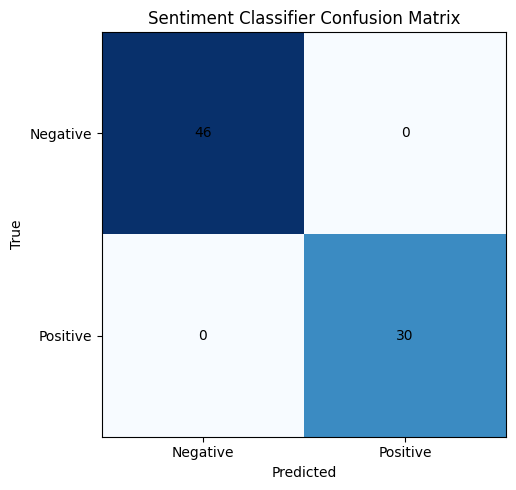

In [34]:
if clf is not None and 'y_test' in globals() and 'y_pred' in globals():
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title('Sentiment Classifier Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.tight_layout()
    plt.show()
else:
    print('Sentiment classifier was not trained or test variables not available.')

✓ Saved dashboard to stock_sentiment_analysis_completed.png


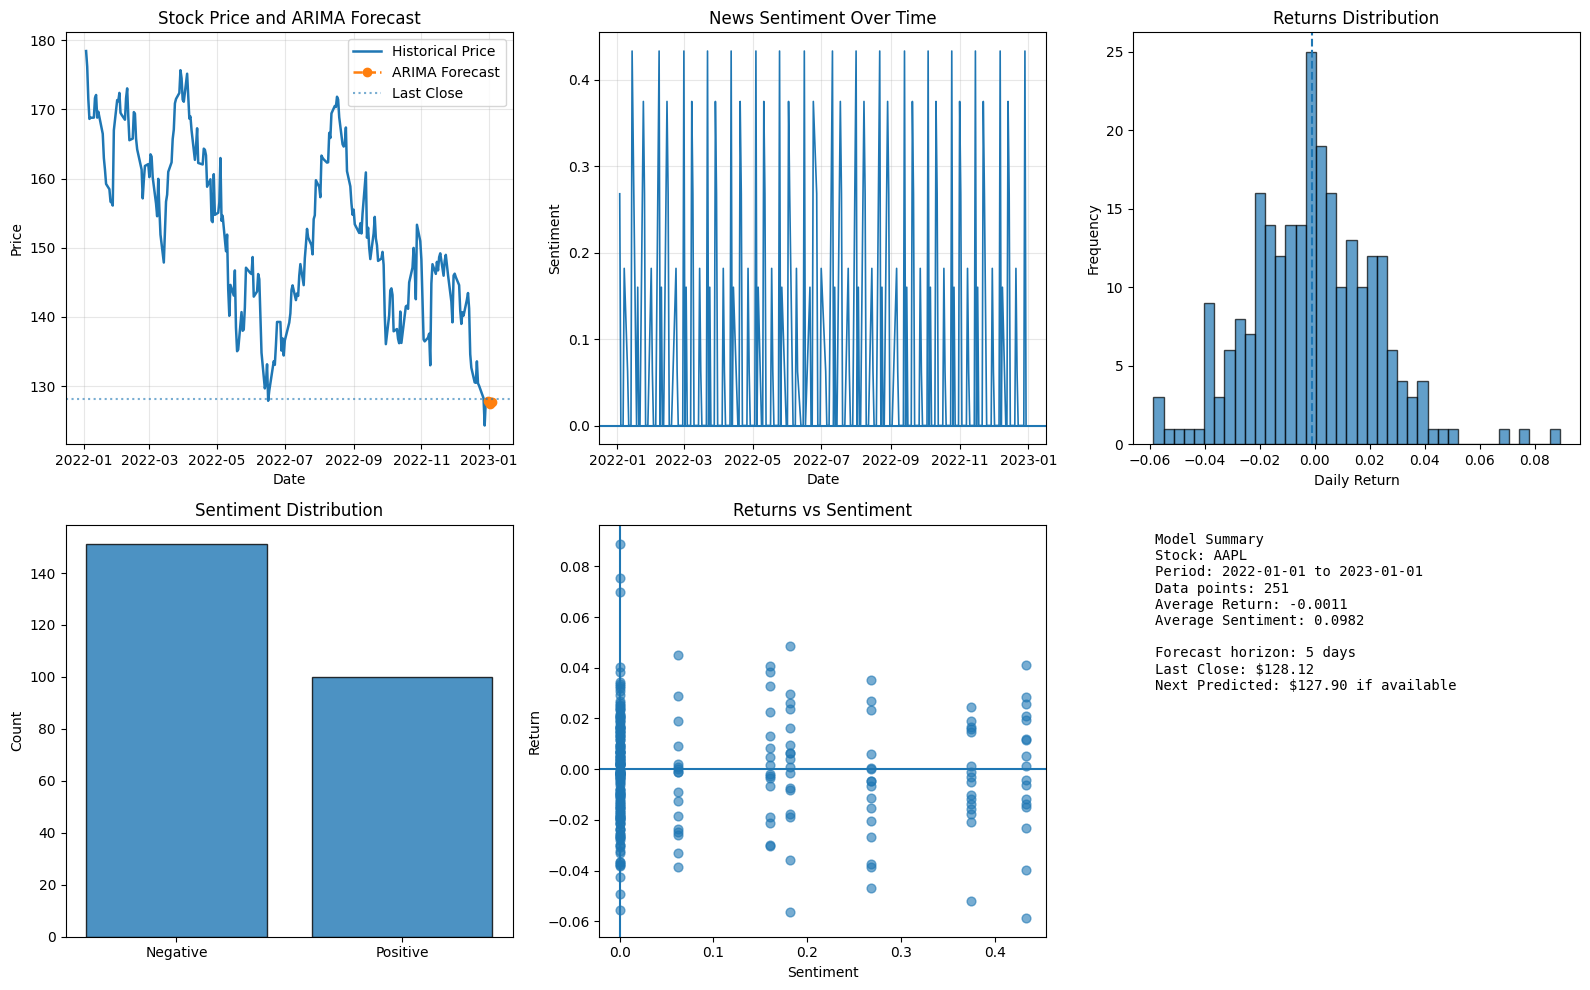

In [35]:
# Comprehensive visualization dashboard
fig = plt.figure(figsize=(16, 10))

# 1. Price and forecast
ax1 = plt.subplot(2, 3, 1)
ax1.plot(stock_data['Date'], stock_data['Close'], label='Historical Price', linewidth=1.8)
forecast_dates = pd.date_range(start=stock_data['Date'].iloc[-1] + timedelta(days=1), periods=len(forecast), freq='D')
ax1.plot(forecast_dates, forecast, '--', label='ARIMA Forecast', linewidth=1.8, marker='o')
ax1.axhline(last_close, linestyle=':', label='Last Close', alpha=0.6)
ax1.set_title('Stock Price and ARIMA Forecast')
ax1.set_xlabel('Date'); ax1.set_ylabel('Price'); ax1.legend(); ax1.grid(alpha=0.3)

# 2. Sentiment over time
ax2 = plt.subplot(2, 3, 2)
ax2.plot(news_data['date'], news_data['sentiment'], linewidth=1.2)
ax2.axhline(0, linestyle='-')
ax2.set_title('News Sentiment Over Time'); ax2.set_xlabel('Date'); ax2.set_ylabel('Sentiment'); ax2.grid(alpha=0.3)

# 3. Returns distribution
ax3 = plt.subplot(2, 3, 3)
rets = stock_data['Return'].dropna()
ax3.hist(rets, bins=40, edgecolor='black', alpha=0.7)
ax3.set_title('Returns Distribution'); ax3.set_xlabel('Daily Return'); ax3.set_ylabel('Frequency')
ax3.axvline(rets.mean(), linestyle='--', linewidth=1.5)

# 4. Sentiment distribution
ax4 = plt.subplot(2, 3, 4)
counts = news_data['sentiment_label'].value_counts().reindex([0,1], fill_value=0)
ax4.bar(['Negative','Positive'], counts.values, edgecolor='black', alpha=0.8)
ax4.set_title('Sentiment Distribution'); ax4.set_ylabel('Count')

# 5. Price Return vs Sentiment scatter
ax5 = plt.subplot(2, 3, 5)
sc = ax5.scatter(merged['sentiment'], merged['Return'], s=40, alpha=0.6)
ax5.set_title('Returns vs Sentiment'); ax5.set_xlabel('Sentiment'); ax5.set_ylabel('Return')
ax5.axhline(0, linestyle='-'); ax5.axvline(0, linestyle='-')

# 6. Model summary text
ax6 = plt.subplot(2, 3, 6); ax6.axis('off')
summary_text = f"""Model Summary
Stock: {TICKER}
Period: {START_DATE} to {END_DATE}
Data points: {len(stock_data)}
Average Return: {rets.mean():.4f}
Average Sentiment: {news_data['sentiment'].mean():.4f}

Forecast horizon: {len(forecast)} days
Last Close: ${last_close:.2f}
Next Predicted: ${float(forecast.iloc[0]):.2f} if available
"""
ax6.text(0.05, 0.98, summary_text, va='top', fontsize=10, family='monospace')

plt.tight_layout()
# Save figure
out_path = 'stock_sentiment_analysis_completed.png'
plt.savefig(out_path, dpi=200, bbox_inches='tight')
print(f'✓ Saved dashboard to {out_path}')
plt.show()


**Next steps / Improvements**
1. Replace synthetic headlines with real news from NewsAPI / Alpha Vantage / RSS feeds.
2. Use a larger labeled dataset for the sentiment classifier, or fine-tune transformer-based models for better accuracy.
3. Use walk-forward validation for time-series forecasting and consider SARIMAX or Prophet for improved results.
4. Combine signals more robustly (weighted ensemble, model calibration, or a meta-classifier).

